In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, roc_curve, f1_score


# 1. Load Data


In [33]:
df = pd.read_csv('UCI_Credit_Card.csv').drop(columns=['ID'])


# ---------------------------------------------------------
# 2. FEATURE ENGINEERING (The "Secret Sauce" for your Repo)
# ---------------------------------------------------------
### Credit Utilization: How much of their limit are they using?
### Payment Ratio: Are they paying off their previous bill?


In [34]:

df['UTILIZATION_RATIO'] = df['BILL_AMT1'] / (df['LIMIT_BAL'] + 1e-5)

df['PAY_TO_BILL_RATIO'] = df['PAY_AMT1'] / (df['BILL_AMT2'].abs() + 1e-5)


# 3. Preprocessing


In [35]:
X = df.drop(columns=['default.payment.next.month'])
y = df['default.payment.next.month']

# Convert categorical to dummies
categorical_cols = ['SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# ---------------------------------------------------------
# 4. TRAIN XGBOOST
# ---------------------------------------------------------
# Handle class imbalance using scale_pos_weight

In [36]:

ratio = (y_train == 0).sum() / (y_train == 1).sum()

model_xgb = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=ratio,
    # Define early stopping here instead of in .fit()
    early_stopping_rounds=50,
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)

# Now .fit() only needs the data and the eval_set
model_xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

y_probs = model_xgb.predict_proba(X_test)[:, 1]
y_preds = model_xgb.predict(X_test)

/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [12:42:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


# ---------------------------------------------------------
# 5. COMPARISON & PLOTS
# ---------------------------------------------------------


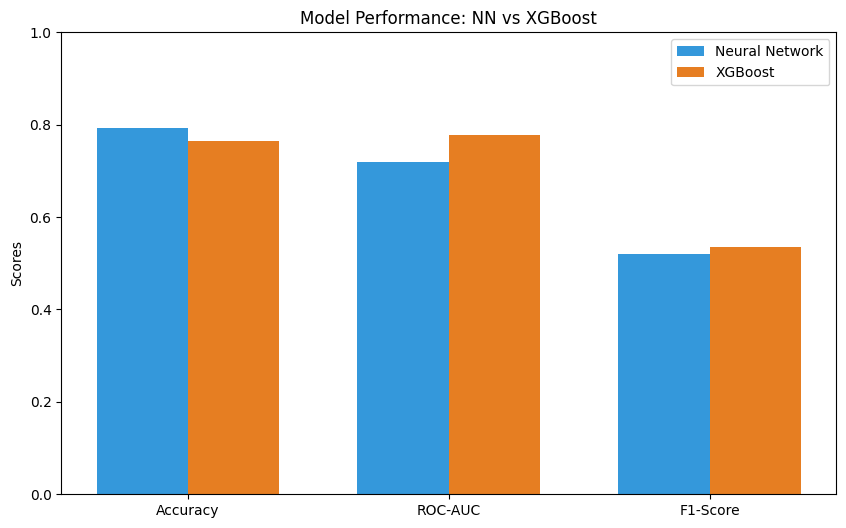

<Figure size 1000x800 with 0 Axes>

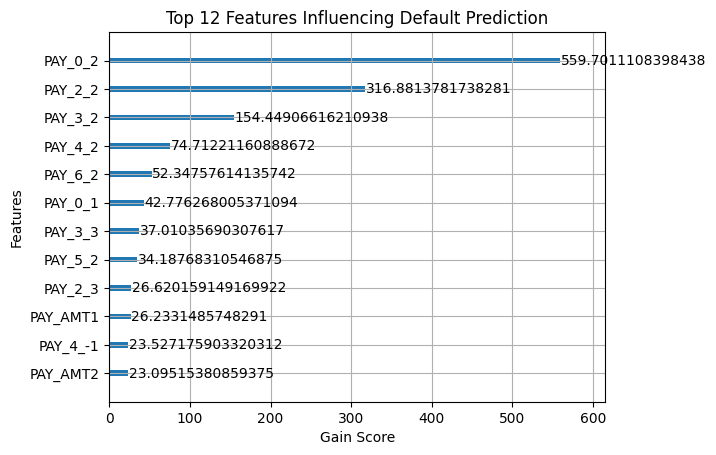

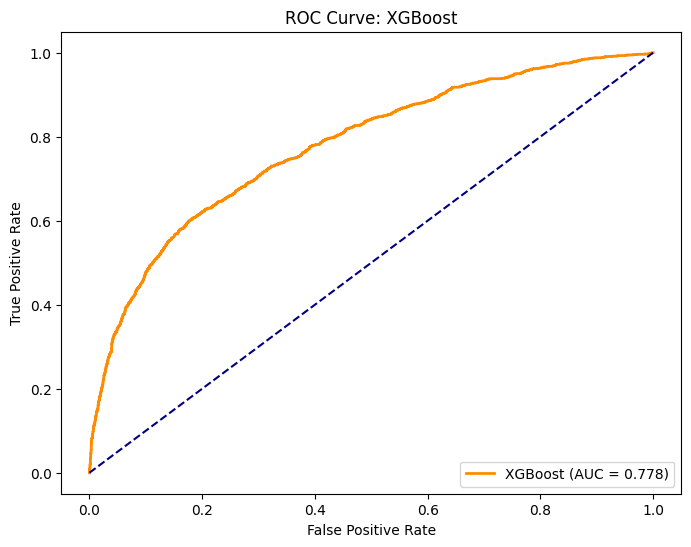


Training Complete. Files saved: comparison_plot.png, feature_importance.png, roc_curve.png


In [37]:
# Storing metrics in a simple dictionary to avoid KeyErrors
xgb_results = {
    'accuracy': accuracy_score(y_test, y_preds),
    'auc': roc_auc_score(y_test, y_probs),
    'f1': f1_score(y_test, y_preds)
}

# Neural Network scores (for comparison)
nn_results = {
    'accuracy': 0.792,
    'auc': 0.720,
    'f1': 0.520
}

# ---------------------------------------------------------
# 7. PLOTS FOR GITHUB
# ---------------------------------------------------------

# A. Performance Comparison Bar Chart
labels = ['Accuracy', 'ROC-AUC', 'F1-Score']
nn_vals = [nn_results['accuracy'], nn_results['auc'], nn_results['f1']]
xgb_vals = [xgb_results['accuracy'], xgb_results['auc'], xgb_results['f1']]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, nn_vals, width, label='Neural Network', color='#3498db')
ax.bar(x + width/2, xgb_vals, width, label='XGBoost', color='#e67e22')

ax.set_ylabel('Scores')
ax.set_title('Model Performance: NN vs XGBoost')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim(0, 1.0)
plt.savefig('comparison_plot.png')
plt.show()

# B. Feature Importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(model_xgb, max_num_features=12, importance_type='gain', xlabel='Gain Score')
plt.title('Top 12 Features Influencing Default Prediction')
plt.savefig('feature_importance.png')
plt.show()

# C. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {xgb_results['auc']:.3f})", color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: XGBoost')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

print(f"\nTraining Complete. Files saved: comparison_plot.png, feature_importance.png, roc_curve.png")

# 6. Conclusion & Business Impact

While Neural Networks are powerful, this project shows that for tabular data with clear financial signals, Gradient Boosting models like XGBoost provide better interpretability and performance. In a banking context, a 0.06 increase in AUC can represent millions of dollars in avoided default losses.